# KPTL Quant Challenge - Modelling

*Author: Rafael Celente*

## Part 0: Introduction

Our goal in this challenge is to analyze and select the best classifications to execute our trading strategies based on a primary labelling model. A primary model has already been built (`side_labels.csv`), which generated long (1) and short (-1) labels. For this challenge, we shall apply different machine learning techniques to create a trading machine that performs on the sides on that have been given. Another dataset (`btc.csv`) has also been given with Bitcoin's OHLCV historic data to extract techical indicators for more features for our model. 

In this notebook we will cover first a data cleaning and overall analysis. Next, we will set our performance indicators and set a baseline of our models using a Dummy Classifier and a Random Forest with only the price as our features. Finally, we will use a technical analysis library to generate technical indicators to feed more features to our model and compare against our baselines. We also use a XGBoost to compare against RF models.



## Part 1: Data cleaning and  normalization


Libraries and utilities import

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pandas_ta as ta
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import datetime
import warnings
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.dummy import DummyClassifier
warnings.filterwarnings('ignore')
datetime.datetime.strptime
sns.set(style="darkgrid")

/home/rafa/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/home/rafa/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing `side_labels.csv` dataframe.

In [2]:
side_labels = pd.read_csv('side_labels.csv')
side_labels['timestamp'] = pd.to_datetime(side_labels['timestamp'])
side_labels = side_labels.set_index('timestamp')

Importing `btc.csv` dataframe.

In [3]:
btc = pd.read_csv('btc.csv')
btc['timestamp'] = pd.to_datetime(btc['timestamp'])
btc = btc.set_index('timestamp')

In [4]:
side_labels.head()

,ret,side
timestamp,,
2016-09-03 19:25:00,0.011372,1.0
2016-09-03 19:40:00,0.007597,1.0
2016-09-11 19:20:00,-0.033881,-1.0
2016-09-11 19:30:00,0.009345,1.0
2016-09-11 19:35:00,-0.000545,-1.0


### Part 1.1 Analyzing the dataset

First let's take a look at how our dataset behaves and map what changes should we apply to improve the model's performance. 

In [5]:
side_labels.side.value_counts()

 1.0    11771
-1.0    10929
 0.0        1
Name: side, dtype: int64

Looking at the data, we see one case in which the model outputed a side 0, which is not normal since our model should be strictly binary. Let's filter this outlier and look at the metrics.

In [6]:
side_labels = side_labels[side_labels['side'] != 0]
side_labels.side.value_counts()

 1.0    11771
-1.0    10929
Name: side, dtype: int64

We can see that our classes are not strictly balanced, as we have more instances of a buy trigger than a sell trigger. Imbalaced classes may induce a bias in our classification, skewing the output towards the majority class.

In [7]:
side_labels.side.value_counts()[1]/side_labels.side.value_counts()[-1]

1.0770427303504437

However, this imbalace is very small (1.077:1). Usually, imbalace may present a problem in datasets in which classes have an imbalace ratio of 2:1 or above.

Let's also take a look at how the indexes are presented. Maybe there are a few instances in which a label is not indexed correctly or a value is null, which will influence our model.

In [8]:
side_labels.isnull().values.any()

False

In [9]:
btc.isnull().values.any()

True

Seems that a few data points on the Bitcoin dataset are missing. Let's take a further look.

In [10]:
btc.isnull().value_counts()

close  open   high   low    volume
False  False  False  False  False     554967
True   True   True   True   False       9801
dtype: int64

We have 9801 data points which have no pricing information whatsoever. Let's see if any of those points share an index with the labels.

In [11]:
nan_values = btc.loc[btc['close'].isnull() == True]

In [12]:
nan_values.index.values in side_labels.index.values

False

No values that return a null value are in our labels.

Let's also change our labels to 0 and 1 to facilitate handling with a few packages we will use (such as XGBoost that doesn't accept negative labels

In [13]:
side_labels.loc[side_labels['side'] == -1, 'side'] = 0
side_labels.head(15)

,ret,side
timestamp,,
2016-09-03 19:25:00,0.011372,1.0
2016-09-03 19:40:00,0.007597,1.0
2016-09-11 19:20:00,-0.033881,0.0
2016-09-11 19:30:00,0.009345,1.0
2016-09-11 19:35:00,-0.000545,0.0
2016-09-11 20:10:00,0.008423,1.0
2016-09-21 00:00:00,0.009991,1.0
2016-09-21 00:05:00,-0.001646,0.0
2016-10-11 04:15:00,-0.007224,0.0


### Part 1.2 Modelling

In here we will apply different models, features and strategies to see their modelling performance.

#### Part 1.2.1 Setting a baseline (Dummy Classifier)

Comparing different models takes not only definition of different performance metrics, but also setting a baseline of comparision. We can use a very simple model to serve as a baseline to compare against other complex classifiers. For this purpose, we will use DummyClassifier, which is a classifier that ignores input features. The model just returns the most frequent class label.

##### 1.2.1.1 Model training

In [14]:
X = btc.loc[side_labels.index, :]
y = side_labels['side']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

dummy_clf = DummyClassifier(strategy = 'prior')
dummy_clf.fit(X_train,y_train)
dummy_clf.predict(X_train)
dummy_clf.score(X_train,y_train)

0.5200440528634361

##### 1.2.1.2 Model testing and performance metrics


##### Performance Metrics
In our classification, we can commit two types of errors: Type I and Type II. We could mislabel an operation that should've been a long as a short (false positive) and mislabel a trade that should've been a short as a long (false negative).The labels that have been correctly categorized are called our true positives and true negatives. The relationship between the ammount of these mislabellings and the ammount of true predictions is of utmost importance, since it influences how well the model's performance is. 


##### Precision

Precision is a measurement of how often our model is able to precisely predict a positive value. It computes the size of true positives against the sum of true positives and false positives.

##### Recall

Recall (aka sensitivity or true positive rate) is a measurement of how accuretely our model is able to identify a true positive against all relevent elements. It computes de size of true positives against the sum of true positives and false negatives.

##### F1-Score

The F1-Score is a measurment of the total test's accuracy. It computes the harmonic mean of the precision and recall, giving a standard numeric computation.

##### Total returns

An import metric we have to look at is the total return of the model. If our model has a bad recall, it might be making bad bets too often, which could lead to negative returns even though the accuracy of the model is still over 50%.


From a financial stakeholder's perspective, minimizing risk and maximizing return is always the goal. In financial machine learning terms, minimizing risk means lowering our false positive rate, in which means lowering the probability of making a bad bet. However, since false positives and false negatives are intrinsically related in a model, lowering the false positive rate also increases the false negative rate, which increases the probability of the model not taking a bet it shouldn't have taken. This lower profit rate is a price we are willing to take to minimize the risk of the trading scheme. Therefore, we are looking to emphasize our model's recall, giving more importance to identifying true positives correctly at the expense of false positives.

With this in mind, for performance metrics, we will be looking at the model's:
- Precision
- Recall
- F1 score
- Accuracy
- Total returns


To visualize the results in a complete and graphical way, we will also look at the model's ROC curve, which will give us a graphical interpretation of our model's performance. The ROC Curve is a graph that plots our Recall over the False Positive Rate. A random classifier plotted in the ROC Curve would yield a point along the diagonal line of the graph, since it has no discriminatory capability.  Since we are trying to maximize our true positive rate and minimize our false positive rate, our classifier is better as closer it gets to the upper left corner of the graph. 

In [15]:
# Plotting utility function

def performance_metrics(classifier, X_test, plot = False):
    y_pred_cls = classifier.predict_proba(X_test)[:, 1]
    y_pred = classifier.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_cls)
    
    class_report = classification_report(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    trades = side_labels.loc[X_test.index]
    trades['predict'] = y_pred
    trades.loc[trades['side'] == 0, 'ret'] = trades['ret']*-1
    profits = trades.loc[trades['side'] == trades['predict'], 'ret'].sum()
    losses = trades.loc[trades['side'] != trades['predict'], 'ret'].sum()
    returns = profits - losses
    
    if plot:
        print(class_report)
        print("Confusion Matrix")
        print(conf_matrix)

        print('')
        print("Accuracy")
        print(acc)

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=f'{classifier.__class__.__name__}')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        
        print(f'Returns:  {returns}')
    
    return class_report, f1, conf_matrix, acc, returns

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2213
         1.0       0.51      1.00      0.68      2327

    accuracy                           0.51      4540
   macro avg       0.26      0.50      0.34      4540
weighted avg       0.26      0.51      0.35      4540

Confusion Matrix
[[   0 2213]
 [   0 2327]]

Accuracy
0.5125550660792951


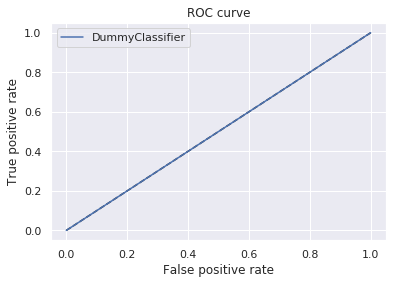

Returns:  2.2763690808617234


In [16]:
dummy_clf.fit(X_train,y_train)
dummy_clf.predict(X_test)
dummy_clf.score(X_test,y_test)


dummy_metrics = performance_metrics(dummy_clf, X_test, plot = True)

From the ROC curve, it is clear that this model isn't much better than a coin flip to predict our trades. Let's explore some more. 

#### Part 1.2.2 Applying a Random Forest Classifier

A Random Forest classifier was selected also to set a formal baseline of our models, since it is very reliable. For the baseline, we will apply the model to features that are readily available: price and volume. However, we expect this model to not perform much better than the Dummy Classifier because of the lack of features. Later, we will apply the RF classifier to a more complete input with more trading features.

In [18]:
# Setting random forest parameters
n_estimator = 1000
depth = 2
RANDOM_STATE = 0

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)

# Fitting our model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, n_estimators=1000, random_state=0)

#### Part 1.2.2.1 RF testing

              precision    recall  f1-score   support

         0.0       0.49      0.78      0.61      2213
         1.0       0.53      0.24      0.33      2327

    accuracy                           0.50      4540
   macro avg       0.51      0.51      0.47      4540
weighted avg       0.52      0.50      0.46      4540

Confusion Matrix
[[1728  485]
 [1769  558]]

Accuracy
0.5035242290748899


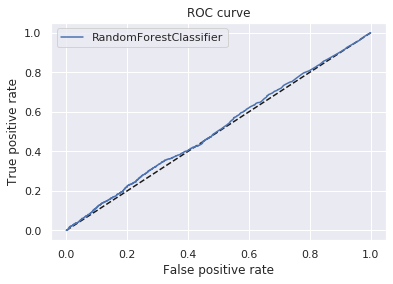

Returns:  1.896193007181342


In [19]:
rf_metrics = performance_metrics(rf, X_test, plot = True)

We can see from these results that, using Bitcoin's price as the only feature, using a Random Forest classifier changed almost nothing of the model's performance compared to the Dummy Classifier. This shows that our model requires more features in order to perform better.

### 1.3 Feature extraction

For feature extraction, we shall test a few technical indications that could potentially indicate a price spike or fall. We can use the python library `pandas-ta` to easilly fetch trading indicators from our `btc.csv` dataset.

In [20]:
import pandas_ta as ta

#### 1.3.1 Technical indicators and correlation

For now, let's explore these technical indicators and see how they perform with our algorithm.

- Exponential Moving Avarege (ema)
- Relative Strength Index (RSI)
- Stochastic Oscillator (stoch)
- Slope (slope)
- Moving Average Convergence Divergence (macd)
- Momemntum (mom)
- Simple Moving Average (sma)

In [21]:
btc = pd.read_csv('btc.csv')
btc['timestamp'] = pd.to_datetime(btc['timestamp'])
btc = btc.set_index('timestamp')
btc = btc.dropna(axis=0)

In [22]:
featured_btc = btc
featured_btc['ema'] = ta.ema(close = btc.close, timeperiod=7)
featured_btc['rsi'] = ta.rsi(close = btc.close)
featured_btc['slope'] = ta.slope(close = btc.close)
featured_btc['mom'] = ta.mom(close = btc.close)
featured_btc['sma'] = ta.sma(close = btc.close)
featured_btc = featured_btc.join(ta.macd(close = btc.close), on='timestamp')
featured_btc = featured_btc.join(ta.stoch(close = btc.close, high = btc.high, low = btc.low), on='timestamp')

##### Feature Engineering

In [23]:
featured_btc.head(40)

,close,open,high,low,volume,ema,rsi,slope,mom,sma,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,STOCHk_14_3_3,STOCHd_14_3_3
timestamp,,,,,,,,,,,,,,,
2016-08-24 00:00:00,582.54,582.39,582.68,582.39,20.057520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-24 00:05:00,582.49,582.68,582.68,582.47,6.698160,NaN,NaN,-0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-24 00:10:00,582.48,582.49,582.49,582.35,4.730530,NaN,NaN,-0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-24 00:15:00,582.28,582.45,582.49,582.28,7.149140,NaN,NaN,-0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-24 00:20:00,582.05,582.32,582.38,582.05,13.120994,NaN,NaN,-0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-24 00:25:00,581.63,582.04,582.20,581.52,31.566578,NaN,NaN,-0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-24 00:30:00,581.75,581.64,581.95,581.64,3.651140,NaN,NaN,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-24 00:35:00,581.20,581.70,581.89,581.12,24.184950,NaN,NaN,-0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-24 00:40:00,581.02,581.23,581.50,580.92,27.750094,NaN,NaN,-0.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's filter out the missing values.

In [24]:
featured_btc = featured_btc.dropna()
featured_btc.head()

,close,open,high,low,volume,ema,rsi,slope,mom,sma,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,STOCHk_14_3_3,STOCHd_14_3_3
timestamp,,,,,,,,,,,,,,,
2016-08-24 02:45:00,581.58,581.32,581.58,581.16,23.293620,581.371074,47.181644,0.25,-0.34,581.230,-0.151001,-0.011326,-0.139675,37.761006,25.937006
2016-08-24 02:50:00,581.10,581.32,581.47,581.10,2.786672,581.321788,38.924918,-0.48,0.02,581.232,-0.166249,-0.021260,-0.144990,35.233253,31.783795
2016-08-24 02:55:00,581.20,581.20,581.34,581.03,10.950970,581.299645,41.232287,0.10,0.02,581.234,-0.168325,-0.018668,-0.149657,32.013201,35.002487
2016-08-24 03:00:00,581.36,581.12,581.38,581.12,3.541770,581.310618,44.824049,0.16,0.14,581.248,-0.155269,-0.004490,-0.150779,24.752475,30.666310
2016-08-24 03:05:00,581.00,581.33,581.34,581.00,17.401130,581.254142,39.042160,-0.36,-0.17,581.231,-0.171988,-0.016967,-0.155021,21.482454,26.082710


Now let's explore the correlation of our new features.

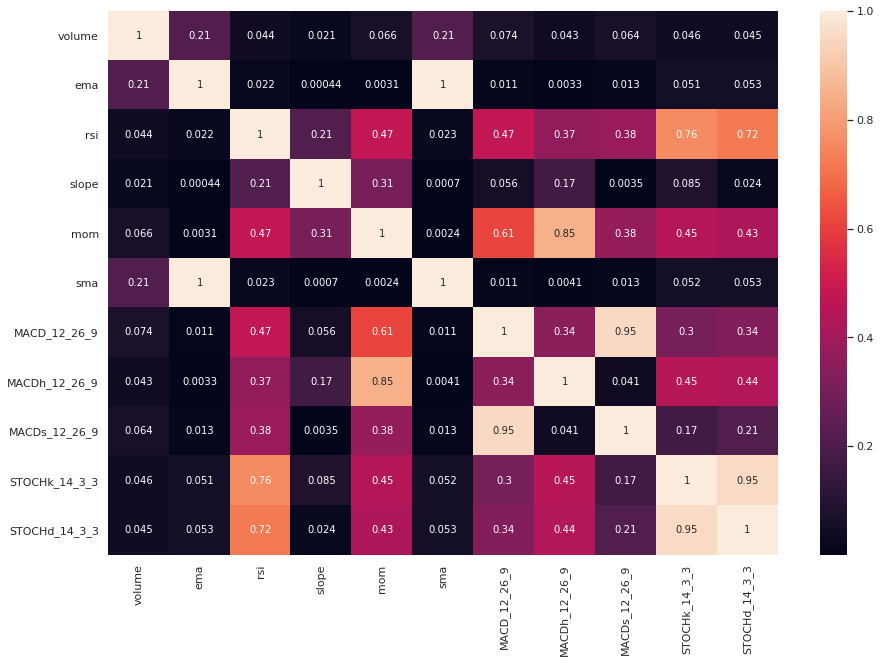

In [25]:
# Correlation matrix
featured_btc = featured_btc.drop(columns=['close', 'open', 'high', 'low'])
var_corr = featured_btc.corr().abs()

plt.rcParams['figure.figsize'] = [15, 10]
sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, annot=True)



We have a pretty colorful heatmap. Some features are highly correlated, while others have next to no correlation. Let's filter the highly correlated features by some threshold to improve our model's performance.

In [26]:
corr_threshold = 0.85
upper = var_corr.where(np.triu(np.ones(var_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] >= corr_threshold)]
featured_btc.drop(to_drop, axis=1, inplace=True)

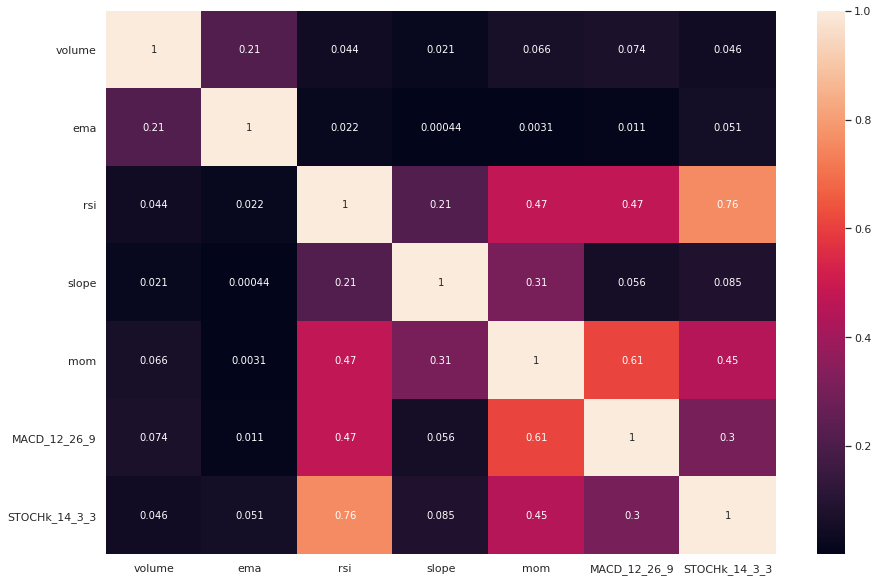

In [27]:
var_corr = featured_btc.corr().abs()

plt.rcParams['figure.figsize'] = [15, 10]
sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, annot=True)


Now we have our features, let's train our model once again and see how it performs.

### 1.4 Model application

#### 1.4.1 RF model with updated features

Let's apply once again a Random Forest algorithm to our new model and track the performance.

In [28]:
X = featured_btc.loc[side_labels.index, :]

In [29]:
# Test/train split
X = featured_btc.loc[side_labels.index, :]
y = side_labels['side']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [30]:
# Setting random forest parameters
n_estimator = 1000
depth = 2
RANDOM_STATE = 0

rf_featured = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)

# Fitting our model
rf_featured.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, n_estimators=1000, random_state=0)

##### 1.4.1.1 RF training

              precision    recall  f1-score   support

         0.0       0.52      0.51      0.52      2213
         1.0       0.54      0.55      0.55      2327

    accuracy                           0.53      4540
   macro avg       0.53      0.53      0.53      4540
weighted avg       0.53      0.53      0.53      4540

Confusion Matrix
[[1132 1081]
 [1047 1280]]

Accuracy
0.5312775330396475


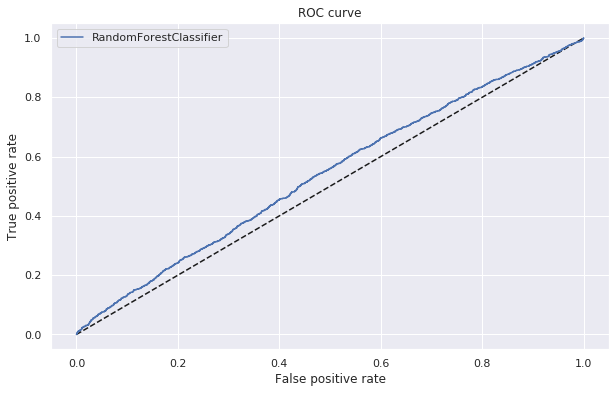

Returns:  3.0999327741585425


In [31]:
plt.rcParams['figure.figsize'] = [10, 6]
featured_rf_metrics = performance_metrics(rf_featured, X_test, plot = True)

The results already show an improvement in our model. Not only the accuracy has increased from 0.5035 to 0.5308, precision, recall and F1-score all improved. Let's see if changing our algorithm has any impact at all in our model.

#### 1.4.2 XGBoost

In [32]:
from xgboost import XGBClassifier

In [33]:
y_train = pd.DataFrame(y_train)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

         0.0       0.50      0.59      0.54      2213
         1.0       0.53      0.45      0.49      2327

    accuracy                           0.52      4540
   macro avg       0.52      0.52      0.51      4540
weighted avg       0.52      0.52      0.51      4540

Confusion Matrix
[[1306  907]
 [1291 1036]]

Accuracy
0.5158590308370044


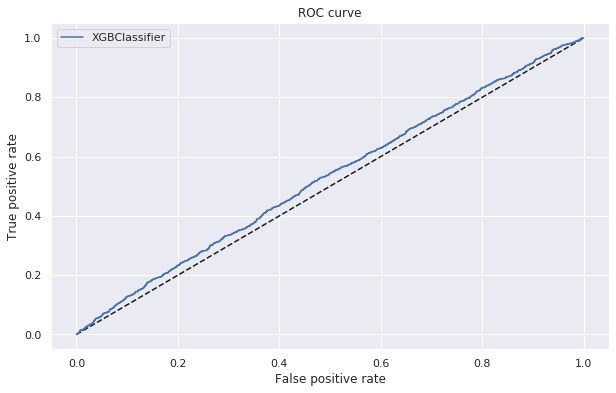

Returns:  2.451157532195211


In [34]:
xgb_metrics = performance_metrics(xgb, X_test, plot = True)

It seems that a XGBoost classifier gave us a worse model based on all of the metrics. This might be because of the overfitting power of the XGBoost.

### 1.5 Model comparision

Let's compare all of our models at once. (Based on https://www.imranabdullah.com/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot)

In [35]:
# Test/train split
X = featured_btc.loc[side_labels.index, :]
y = side_labels['side']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [44]:
classifiers = [LogisticRegression(random_state=1234), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               RandomForestClassifier(max_depth=2, n_estimators=1000,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=0),
               XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','class_report', 'f1','conf_matrix', 'acc', 'returns'])
for cls in classifiers:
    print(f'Training {cls.__class__.__name__}')
    model = cls.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    class_report, f1, conf_matrix, acc, returns = performance_metrics(cls, X_test, plot = False)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr,
                                        'tpr':tpr,
                                        'class_report':class_report,
                                        'f1':f1,
                                        'conf_matrix': conf_matrix,
                                        'acc': acc,
                                        'returns': returns}, ignore_index=True)
    print('Done\n')
result_table.set_index('classifiers', inplace=True)

Training LogisticRegression
Done

Training GaussianNB
Done

Training KNeighborsClassifier
Done

Training RandomForestClassifier
Done

Training XGBClassifier
Done



ROC Curve analysis.

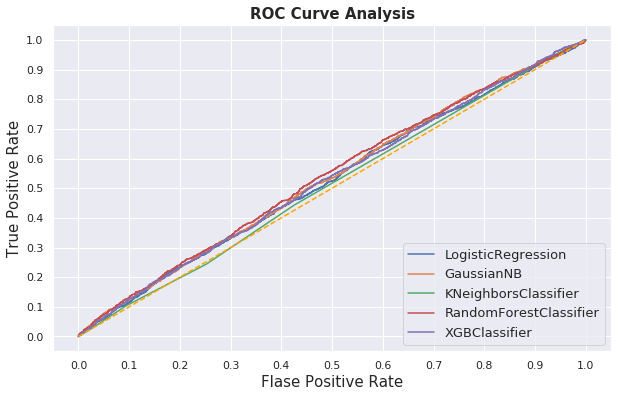

In [47]:
fig = plt.figure(figsize=(10,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}".format(i))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

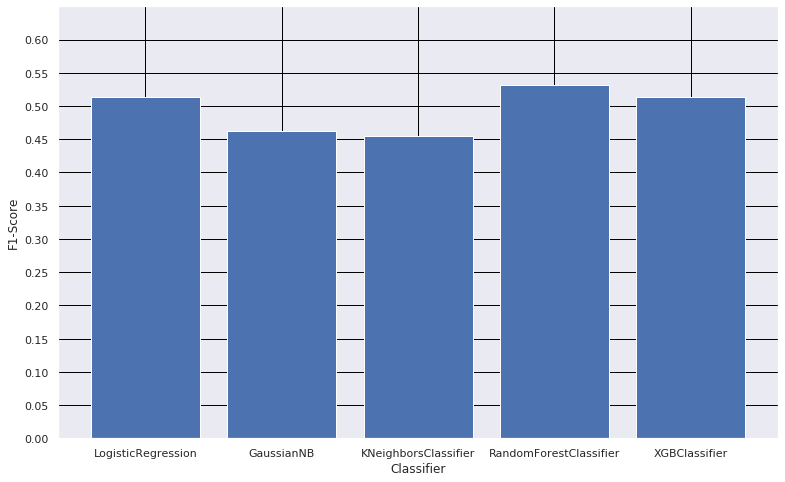

In [52]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_axes([0,0,1,1])
classifiers = result_table.index
f1 = result_table['f1']
ax.bar(classifiers, f1)

plt.grid(color = 'black')
plt.yticks(np.arange(0, 0.65, 0.05))

plt.xlabel('Classifier')
plt.ylabel('F1-Score')
plt.ylim([0,0.65])
plt.show()

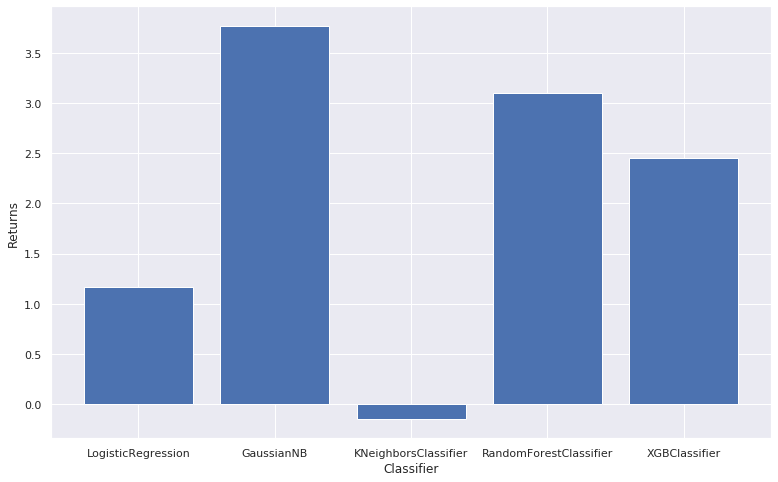

In [40]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_axes([0,0,1,1])
classifiers = result_table.index
returns = result_table['returns']
ax.bar(classifiers, returns)
plt.xlabel('Classifier')
plt.ylabel('Returns')
plt.show()

From this analysis, we can see a few interesting results.

The GaussianNB had the best total returns overall in our backtest. From a naive financial stand point, this would suffice. However, this model resulted in one of the worst F1-Scores, which might be because the Gaussian Naive Bayes classifier is a simple probabilistic classifier, so it can overfit for the bullish nature of Bitcoin. This hypothesis is supported by the model's F1-score of each of the labels.

In [41]:
print(result_table['class_report']['GaussianNB'])

              precision    recall  f1-score   support

         0.0       0.55      0.17      0.26      2213
         1.0       0.52      0.87      0.65      2327

    accuracy                           0.53      4540
   macro avg       0.54      0.52      0.46      4540
weighted avg       0.54      0.53      0.46      4540



This result shows that the GaussianNB is not a very good model for our shorting trades specifically for Bitcoin.

From the data performance metrics we set, the probable best model we can use is based on a Random Forest. This model had the best F1-score of the models tested and had the second best total returns. However, tuning a few more hyperparameters, I believe the XGBoost could overtake the RF model.

### 1.6 Conclusions

After all the process of data cleaning, model baseline setting, performance metrics setting, feature engineering, feature extraction, model selection and model comparision, we could conclude that for all the models here tested with the features: 

- Exponential Moving Avarege (ema)
- Relative Strength Index (RSI)
- Stochastic Oscillator (stoch)
- Slope (slope)
- Moving Average Convergence Divergence (macd)
- Momemntum (mom)
- Simple Moving Average (sma)

and based on these performance metrics: 

- Precision
- Recall
- F1 score
- Accuracy
- Total returns

the best overall model is an application of a Random Forest algorithm. However, the hyperparameter tuning of the XGBoost wasn't ideal. With a few tweaks, it is possible that it outperforms the RF in future results. A more thorough analysis of these hyperparameters could be beneficial before applying these models.

Also, a better primary model, based on a meta-labelling technique, could be built to further reduce the recall of the whole model. This process would yield worst total returns specially for bullish or bearish markets, but with a general application in mind, this approach would lead to a higher recall rate and better overall performance.

